## **MuonBatch._hits has NaNs**


Has demonstrated at the end of `muon_prop_through_hodoscopes.ipynb` notebook, **`ScatterBatch`** has **no hits** to use when using the overlap hodoscope configuration.

This error originates from `MuonBatch._hits` which contains NaN values. Let's try to replicate this error.

In [1]:
from volume.hodoscope_init_config import get_overlap_hod_config

volume = get_overlap_hod_config()


In [2]:
from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper
from functools import partial
from tomopt.optimisation import VoxelX0Loss

import torch

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

In [3]:
from tomopt.core import X0
from torch import Tensor

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['water']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length,arb_rad_length], shuffle=True)

In [4]:
from tomopt.optimisation.callbacks import MuonResampler, ScatterRecord, HitRecord
from tomopt.optimisation import PredHandler, ScatterRecord, HitRecord

sr = ScatterRecord()
hr = HitRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=10000, 
                        mu_bs=250, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr])

The `wrapper.predict()` method calls `wrapper._scan_volumes()`, which itself calls the `wrapper._scan_volume()`. The latter basically runs:

```python
self.fit_params.mu = MuonBatch(self.mu_generator(self.fit_params.mu_bs), init_z=self.volume.h, device=self.fit_params.device)

self.volume(self.fit_params.mu)

self.fit_params.sb = self.partial_scatter_inferrer(mu=self.fit_params.mu, volume=self.volume)

self.fit_params.volume_inferrer.add_scatters(self.fit_params.sb)

self.fit_params.pred = self.fit_params.volume_inferrer.get_prediction()

```

In [10]:
from volume.hodoscope_init_config import get_standard_hod_config

# define volume
volume = get_standard_hod_config()

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['iron']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length], shuffle=True)

volume.load_rad_length(arb_rad_length)

from tomopt.muon import MuonGenerator2016
from tomopt.muon import MuonBatch

# generate muons
gen = MuonGenerator2016(x_range=[0.25,0.75], y_range=[0.25,0.75], theta_range=[0.001, 0.2], energy_range=[1.,4.])
muons = MuonBatch(xy_p_theta_phi=gen.generate_set(1000), init_z = 2.)

from tomopt.core import X0

# Propagate muons
volume(muons)

In [11]:
from tomopt.inference.scattering import ScatterBatch

sb = ScatterBatch(mu = muons, volume = volume)

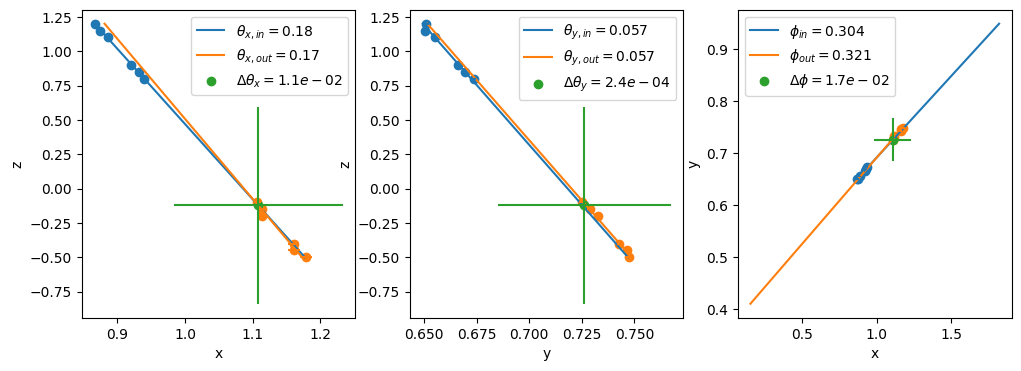

In [12]:
import numpy as np
sb.plot_scatter(idx=np.random.randint(1000))

In [13]:
pocas = sb.poca_xyz.detach().numpy()

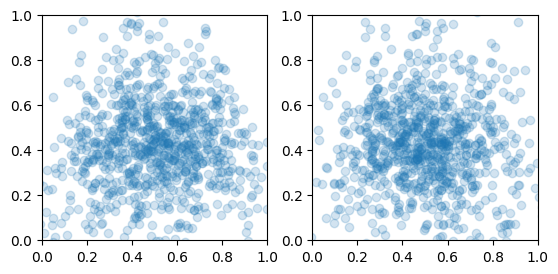

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=2)
axs[0].scatter(pocas[:,0], pocas[:,2], alpha = .2)
axs[1].scatter(pocas[:,1], pocas[:,2], alpha = .2)


for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim([0., 1.])
    ax.set_ylim([0., 1.])

